## Imports

In [7]:
from wapiti import wapiti_tools, wapiti

import os

import numpy as np
import pandas as pd
import random
import scipy
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.optimize import minimize

from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import LombScargle

from wpca import WPCA


from matplotlib import pyplot as plt
import seaborn

from tqdm import tqdm

seaborn.set_context("notebook")
plt.rcParams["axes.grid"] = False
cwd = os.getcwd()  # current working directory
frequency = np.linspace(1/1000, 1/1.1, 100000) # periodogram frequency grid

## Load data

In [8]:
target = 'GL1289'

path = '/media/paul/One Touch2/SPIRou_Data/0.7.275/EV_LAC/EV_LAC' #### PATH TO CHANGE ####
os.chdir(path)
d2vs_all = []
dd2vs_all = []
rvs_all = []
drvs_all = []
times_lbl = []
berv = []
print('loading data...')
for (root, dirs, file) in os.walk(path):
    for f in tqdm(sorted(file)):
        if 'lbl.fits' in f:
            nthfile = fits.open(f, memmap=False)
            times_lbl.append(nthfile[0].header['BJD'])
            berv.append(nthfile[0].header['BERV'])
            d2vs_all.append(nthfile[1].data['d2v'])
            dd2vs_all.append(nthfile[1].data['sd2v'])
            rvs_all.append(nthfile[1].data['dv'])
            drvs_all.append(nthfile[1].data['sdv'])
            nthfile.close()

d2vs_all = np.array(d2vs_all)
dd2vs_all = np.array(dd2vs_all)
rvs_all = np.array(rvs_all)
drvs_all = np.array(drvs_all)
times_lbl = np.array(times_lbl)
berv = np.array(berv)

p1 = fits.open('/media/paul/One Touch2/SPIRou_Data/0.7.275/EV_LAC/EV_LAC/2437482o_pp_e2dsff_tcorr_AB_EV_LAC_EV_LAC_lbl.fits') #### PATH TO CHANGE ####
wave_start, wave_end = p1[1].data['WAVE_START'], p1[1].data['WAVE_END']
waves = (p1[1].data['WAVE_START']+p1[1].data['WAVE_END'])/2.
depth = p1[1].data['LINE_DEPTH']

  2%|▏         | 11/705 [00:00<00:06, 102.11it/s]

loading data...


100%|██████████| 705/705 [00:07<00:00, 94.33it/s] 


In [9]:
g = np.mean(np.isfinite(d2vs_all),axis=0)
valid = g >= 0.5
d2vs_all, dd2vs_all = d2vs_all[:, valid], dd2vs_all[:, valid]
rvs_all, drvs_all = rvs_all[:, valid], drvs_all[:, valid]

In [10]:
d2vs_binned = []
dd2vs_binned = []
dvs_binned = []
ddvs_binned = []

for idx in tqdm(range(d2vs_all.shape[1]), leave=False):

    time_binned, d2v, dd2v = wapiti_tools.night_bin(times_lbl, d2vs_all[:, idx], dd2vs_all[:, idx])
    __, dv, ddv = wapiti_tools.night_bin(times_lbl, rvs_all[:, idx], drvs_all[:, idx])
    
    d2vs_binned.append(d2v)
    dd2vs_binned.append(dd2v)
    
    dvs_binned.append(dv)
    ddvs_binned.append(ddv)

d2vs_binned = np.array(d2vs_binned).T
dd2vs_binned = np.array(dd2vs_binned).T

dvs_binned = np.array(dvs_binned).T
ddvs_binned = np.array(ddvs_binned).T

In [11]:
# Create masked arrays for the used RVs and RV uncertainties, masking any NaN values
ma_d2vs = np.ma.MaskedArray((d2vs_binned.T), mask=np.isnan((d2vs_binned.T)))
ma_dd2vs = np.ma.MaskedArray((dd2vs_binned.T), mask=np.isnan((dd2vs_binned.T)))

# Compute the average and variance of the used RVs and RV uncertainties using the masked arrays
average = np.ma.average(ma_d2vs, weights=1/ma_dd2vs**2, axis=1)
variance = np.ma.average((ma_d2vs-average.reshape(-1, 1))**2, weights=1/ma_dd2vs**2, axis=1)

# Reshape the averages and standard deviations into column vectors
mean_X = average.data.reshape(-1, 1)
std_X = np.sqrt(variance.data.reshape(-1, 1))

# Normalize the used RVs and RV uncertainties
X = (np.copy(d2vs_binned.T)-mean_X)/std_X
dX = np.copy(dd2vs_binned.T)/std_X
weights = 1/dX
weights[np.isnan(X)] = 0 

Text(0, 0.5, 'standardized dLW')

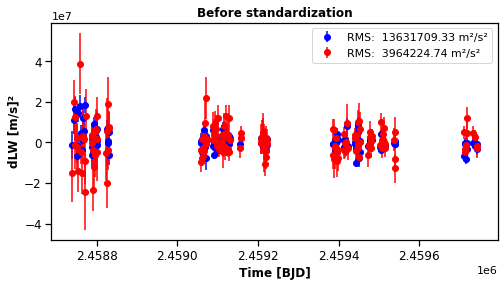

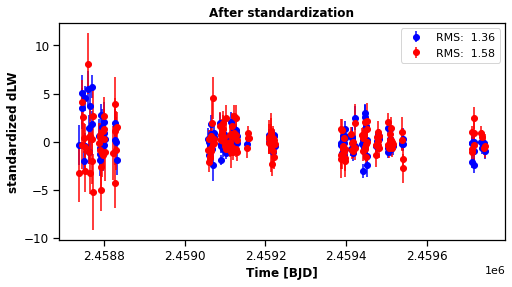

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.set_title('Before standardization', fontsize=12, weight='bold')
idx_max = np.argmax(np.nanstd(d2vs_binned, axis=1))
idx_min = np.argmin(np.nanstd(d2vs_binned, axis=1))

ax.errorbar(time_binned, d2vs_binned[:, idx_max], dd2vs_binned[:, idx_max], fmt='bo', label = f'RMS: {np.max(np.nanstd(d2vs_binned, axis=1)): .2f} m²/s²')
ax.errorbar(time_binned, d2vs_binned[:, idx_min], dd2vs_binned[:, idx_min], fmt='ro', label = f'RMS: {np.min(np.nanstd(d2vs_binned, axis=1)): .2f} m²/s²')
ax.legend()
ax.tick_params(labelsize=12)
ax.set_xlabel('Time [BJD]', fontsize=12, weight='bold')
ax.set_ylabel('dLW [m/s]²', fontsize=12, weight='bold')

fig, ax = plt.subplots(figsize=(8, 4))

ax.set_title('After standardization', fontsize=12, weight='bold')
idx_max = np.argmax(np.nanstd(d2vs_binned, axis=1))
idx_min = np.argmin(np.nanstd(d2vs_binned, axis=1))

ax.errorbar(time_binned, X[idx_max], dX[idx_max], fmt='bo', label = f'RMS: {np.nanstd(X[idx_max]): .2f}')
ax.errorbar(time_binned, X[idx_min], dX[idx_min], fmt='ro', label = f'RMS: {np.nanstd(X[idx_min]): .2f}')
ax.legend()
ax.tick_params(labelsize=12)
ax.set_xlabel('Time [BJD]', fontsize=12, weight='bold')
ax.set_ylabel('standardized dLW', fontsize=12, weight='bold')

In [13]:
p_val = wapiti.compute_p_values(X, weights)

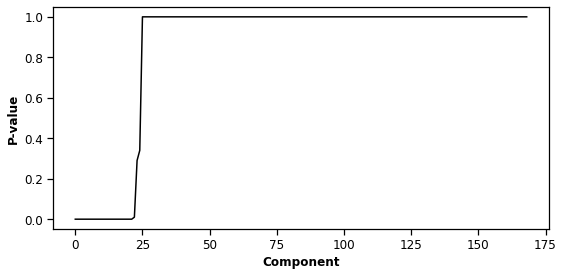

In [14]:
# Initialize a figure
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the p-value of the components
ax.plot(p_val, 'k-')
# Set the y-label and x-label for the plot
ax.set_ylabel('P-value', size=12, weight='bold')
ax.set_xlabel('Component', size=12, weight='bold')
# Set the font size for the tick labels on the first subplot
ax.tick_params(labelsize=12)
# Adjust the layout of the figure
plt.tight_layout()
# Display the figure
plt.show()
# Close the figure to free up memory
plt.close()

In [15]:
n_components = 0
while p_val[n_components] < 1e-5:
    n_components += 1
print(f'{n_components} components are retained after the permutation test.')

22 components are retained after the permutation test.


In [16]:
pearson_array = wapiti.lpocv(X, weights, n_components)
pearson = np.nanmean(pearson_array, axis=1)

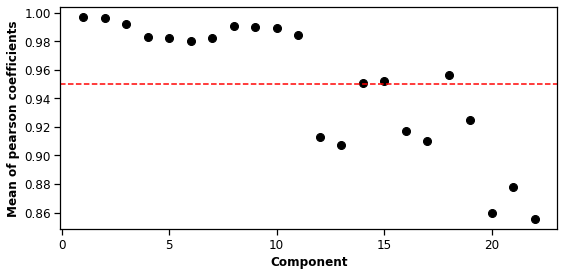

In [17]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(np.arange(1, len(pearson)+1), pearson, 'ko', markersize='8')
ax.axhline(0.95, linestyle='--',color='r')
ax.set_ylabel('Mean of pearson coefficients', size=12, weight='bold')
# Set the x-axis label
ax.set_xlabel('Component', size=12, weight='bold')
# Set the font size of the tick labels
ax.tick_params(labelsize=12)
plt.tight_layout()
plt.show()
plt.close()

In [18]:
n_components = 0
while pearson[n_components] >= 0.95:
    n_components += 1
print(f'{n_components} components are retained after the leave-p out cross validation test.')

11 components are retained after the leave-p out cross validation test.


In [19]:
# Fit WPCA model
pca = WPCA(n_components=n_components)
pca.fit(X, weights=weights)

WPCA(n_components=11)

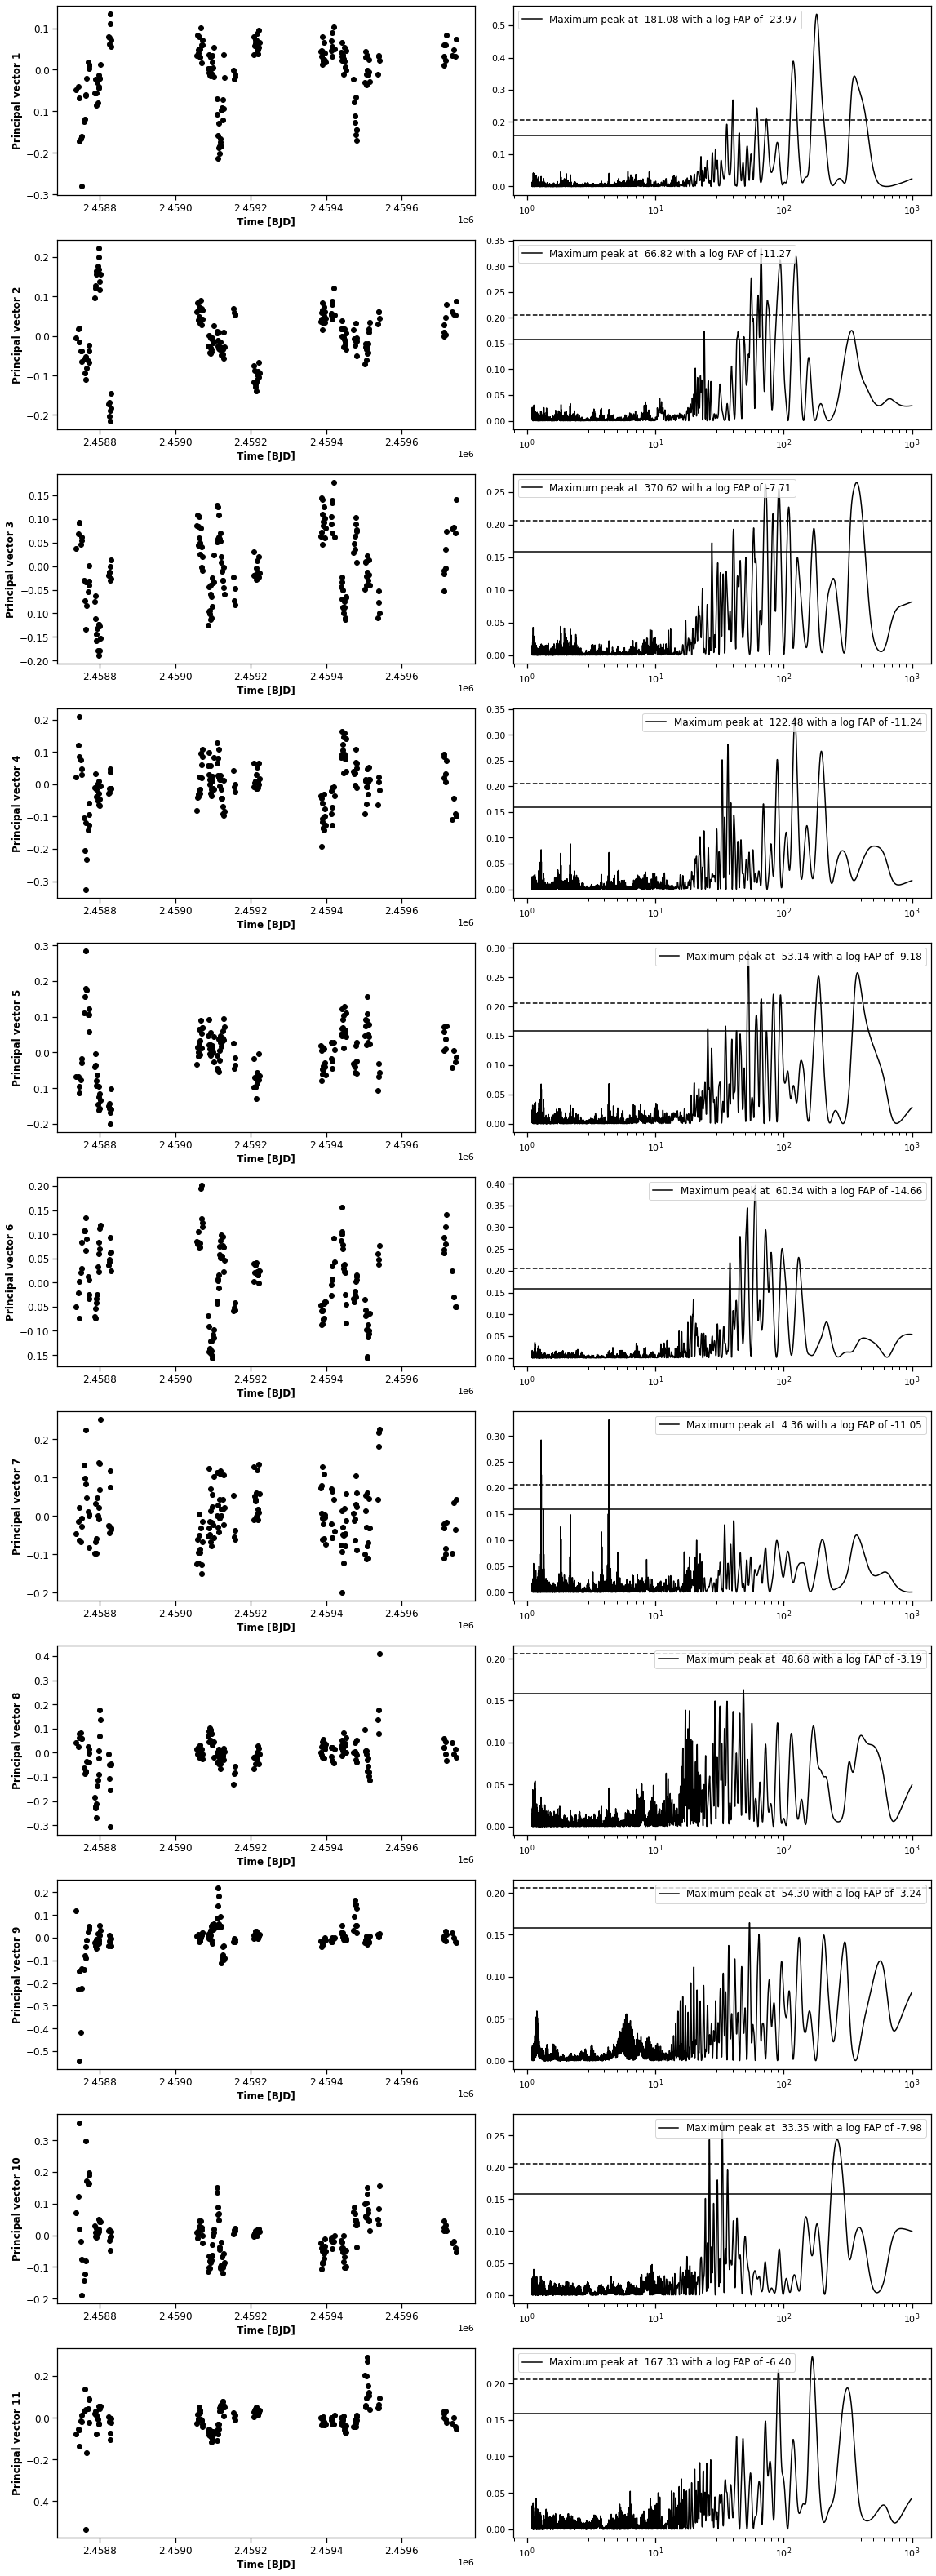

In [20]:
fig, ax = plt.subplots(n_components, 2, figsize=(16, n_components*4))

for n in range(n_components):
    
    ax[n, 0].plot(time_binned, pca.components_[n], 'ko')
    
    ax[n, 0].set_ylabel(f'Principal vector {n+1}', size=12, weight='bold')
    # Set the x-axis label
    ax[n, 0].set_xlabel('Time [BJD]', size=12, weight='bold')
    # Set the font size of the tick labels
    ax[n, 0].tick_params(labelsize=12)

    ls = LombScargle(time_binned, pca.components_[n])
    power = ls.power(frequency)
    fap = ls.false_alarm_probability(power.max())
    ax[n, 1].semilogx(1/frequency, power, 'k-', label=f'Maximum peak at {1/frequency[np.argmax(power)]: .2f} with a log FAP of {np.log10(fap):.2f}')
    fap =ls.false_alarm_probability(power.max())
    ax[n, 1].legend(fontsize=12)

    # false alarm levels
    fap = ls.false_alarm_level(1e-3)
    ax[n, 1].axhline(y=fap,linestyle="-",color="k")
    fap = ls.false_alarm_level(1e-5)
    ax[n, 1].axhline(y=fap,linestyle="--",color="k")


plt.tight_layout()

Prot seems to be in the 5th vector


In [21]:
n_rots = [6]

In [22]:
U, dU = wapiti_tools.get_scores(X, dX, weights, n_components)

In [23]:
mean_score = np.average(U, weights = 1/dU**2, axis=0)
U_tilde = []
dU_tilde = []
for n in n_rots:
    U_tilde.append((U[:, n] - mean_score[n])/dU[:,n])
U_tilde = np.array(U_tilde).T
dU_tilde = np.ones_like(U_tilde)

zscores = []
for n in range(len(n_rots)):
    zscore = (U_tilde[:, n] - np.nanmean(U_tilde[:, n]))/np.std(U_tilde[:, n])
    zscores.append(np.abs(zscore))
zscores = np.nanmax(zscores, axis=0)

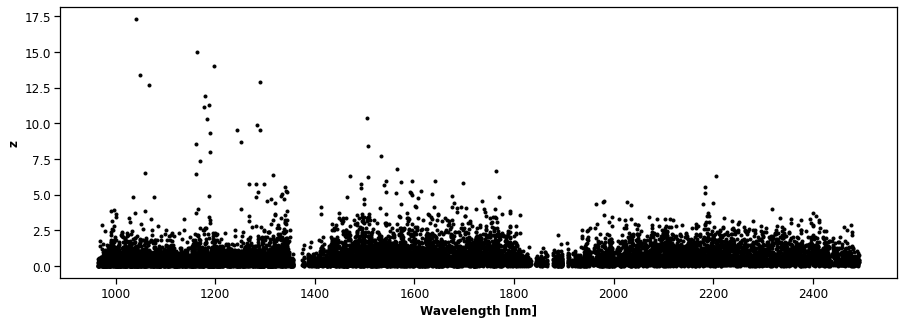

In [24]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(waves[valid], zscores, 'k.')
ax.set_ylabel(f'z', size=12, weight='bold')
# Set the x-axis label
ax.set_xlabel('Wavelength [nm]', size=12, weight='bold')
# Set the font size of the tick labels
ax.tick_params(labelsize=12)

In [25]:
z0 = 2
waves_impacted = zscores >= z0

print(zscores[waves_impacted].shape[0], 'lines impacted')

712 lines impacted


(-1.0, 0.2)

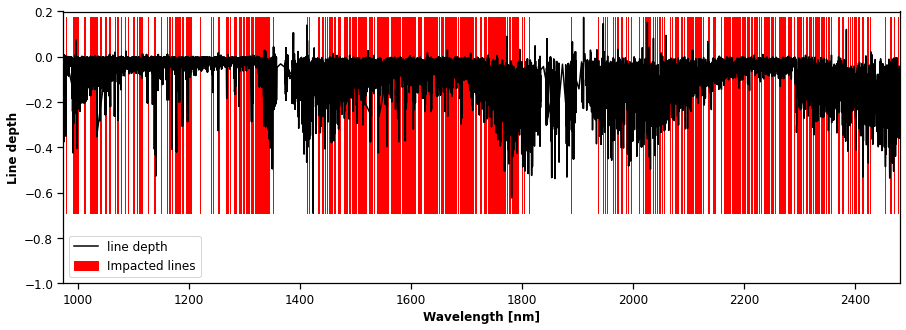

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(waves, depth, 'k-', label = 'line depth')
for idx in range(zscores[waves_impacted].shape[0]):
    ax.fill_betweenx(np.linspace(np.nanmin(depth), np.nanmax(depth), 100), wave_start[valid][waves_impacted][idx], wave_end[valid][waves_impacted][idx], color='r')
    
ax.fill_betweenx(np.linspace(np.nanmin(depth), np.nanmax(depth), 100), wave_start[valid][waves_impacted][idx], wave_end[valid][waves_impacted][idx], color='r', label='Impacted lines')

ax.legend(fontsize=12)
ax.set_xlim(np.nanmin(wave_start[valid][waves_impacted]),  np.nanmax(wave_end[valid][waves_impacted]))
ax.set_ylabel(f'Line depth', size=12, weight='bold')
# Set the x-axis label
ax.set_xlabel('Wavelength [nm]', size=12, weight='bold')
# Set the font size of the tick labels
ax.tick_params(labelsize=12)
ax.set_ylim(-1, 0.2)

In [27]:
file_name = target+'_impacted_lines_z0_'+str(z0)+'.rdb'

index_sort = np.argsort(zscores[waves_impacted])[::-1]

path = cwd+'/'
# Combine the data arrays into a single 2D array
data = np.column_stack((zscores[waves_impacted][index_sort], wave_start[valid][waves_impacted][index_sort], wave_end[valid][waves_impacted][index_sort], depth[valid][waves_impacted][index_sort]))

# Create a list of column names
col_names = ['z', 'Wave Start [nm]', 'Wave End [nm]', 'Line Depth']

# Add the target name to the column names
col_names = [f"{col}" for col in col_names]

# Save the data to the file
header = '\t'.join(col_names) + '\n'
np.savetxt(path+'/'+file_name, data, header=header, comments='', delimiter='\t')

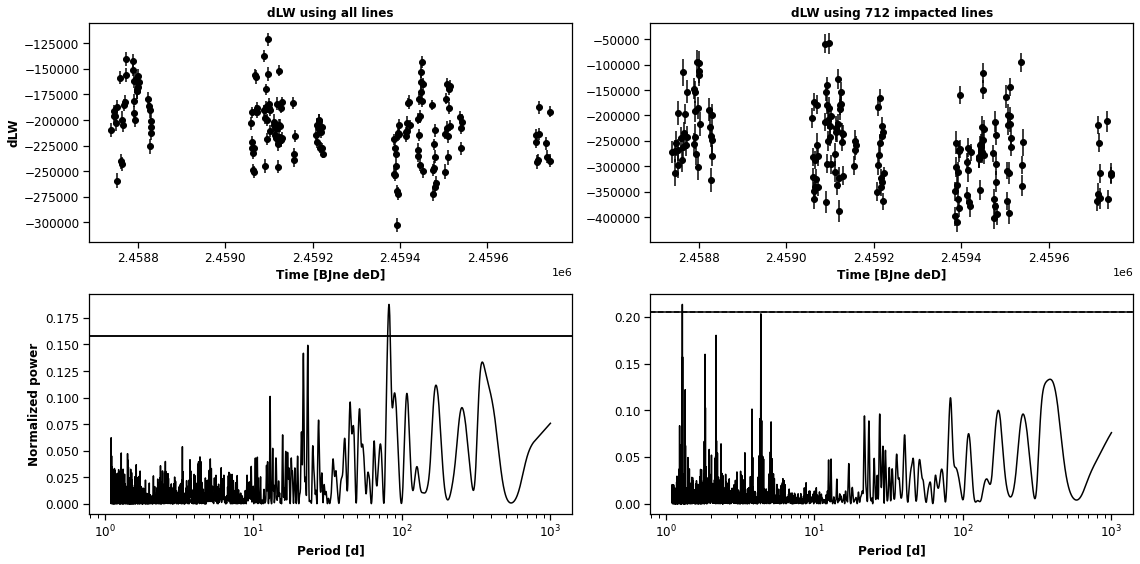

In [28]:
d2v_0, std_d2v_0 = [], []
for idx in tqdm(range(len(time_binned)), leave=False):
    d2v_temp, std_d2v_temp = wapiti_tools.odd_ratio_mean(d2vs_binned[idx], dd2vs_binned[idx])
    d2v_0.append(d2v_temp)
    std_d2v_0.append(std_d2v_temp)
d2v_0, std_d2v_0 = np.array(d2v_0), np.array(std_d2v_0)


fig, ax = plt.subplots(2, 2, figsize=(16,8))
ax[0, 0].errorbar(time_binned, d2v_0, std_d2v_0, fmt='ko')
ls = LombScargle(time_binned, d2v_0, std_d2v_0)
power = ls.power(frequency)
ax[1, 0].semilogx(1/frequency, power, 'k-')

d2v_0, std_d2v_0 = [], []
for idx in tqdm(range(len(time_binned)), leave=False):
    d2v_temp, std_d2v_temp = wapiti_tools.odd_ratio_mean(d2vs_binned[idx, waves_impacted], dd2vs_binned[idx, waves_impacted])
    d2v_0.append(d2v_temp)
    std_d2v_0.append(std_d2v_temp)
d2v_0, std_d2v_0 = np.array(d2v_0), np.array(std_d2v_0)

ax[0, 1].errorbar(time_binned, d2v_0, std_d2v_0, fmt='ko')
ls = LombScargle(time_binned, d2v_0, std_d2v_0)
power = ls.power(frequency)
ax[1, 1].semilogx(1/frequency, power, 'k-')
fap = ls.false_alarm_probability(power.max())

# false alarm levels
fap = ls.false_alarm_level(1e-3)
ax[1, 0].axhline(y=fap,linestyle="-",color="k")
ax[1, 0].axhline(y=fap,linestyle="-",color="k")
fap = ls.false_alarm_level(1e-5)
ax[1, 1].axhline(y=fap,linestyle="--",color="k")
ax[1, 1].axhline(y=fap,linestyle="-",color="k")

ax[0, 0].set_ylabel(f'dLW', size=12, weight='bold')
ax[0, 0].set_xlabel('Time [BJne deD]', size=12, weight='bold')
ax[0, 1].set_xlabel('Time [BJne deD]', size=12, weight='bold')

ax[1, 0].set_ylabel(f'Normalized power', size=12, weight='bold')
ax[1, 0].set_xlabel(f'Period [d]', size=12, weight='bold')
ax[1, 1].set_xlabel(f'Period [d]', size=12, weight='bold')

ax[0, 0].tick_params(labelsize=12)
ax[0, 1].tick_params(labelsize=12)
ax[1, 0].tick_params(labelsize=12)
ax[1, 1].tick_params(labelsize=12)

ax[0, 0].set_title('dLW using all lines', fontsize=12, weight='bold')
ax[0, 1].set_title(f'dLW using {zscores[waves_impacted].shape[0]} impacted lines', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()
plt.close()

In [29]:
# Fit WPCA model
pca = WPCA(n_components=n_components)
pca.fit(X[waves_impacted], weights=weights[waves_impacted])

WPCA(n_components=11)

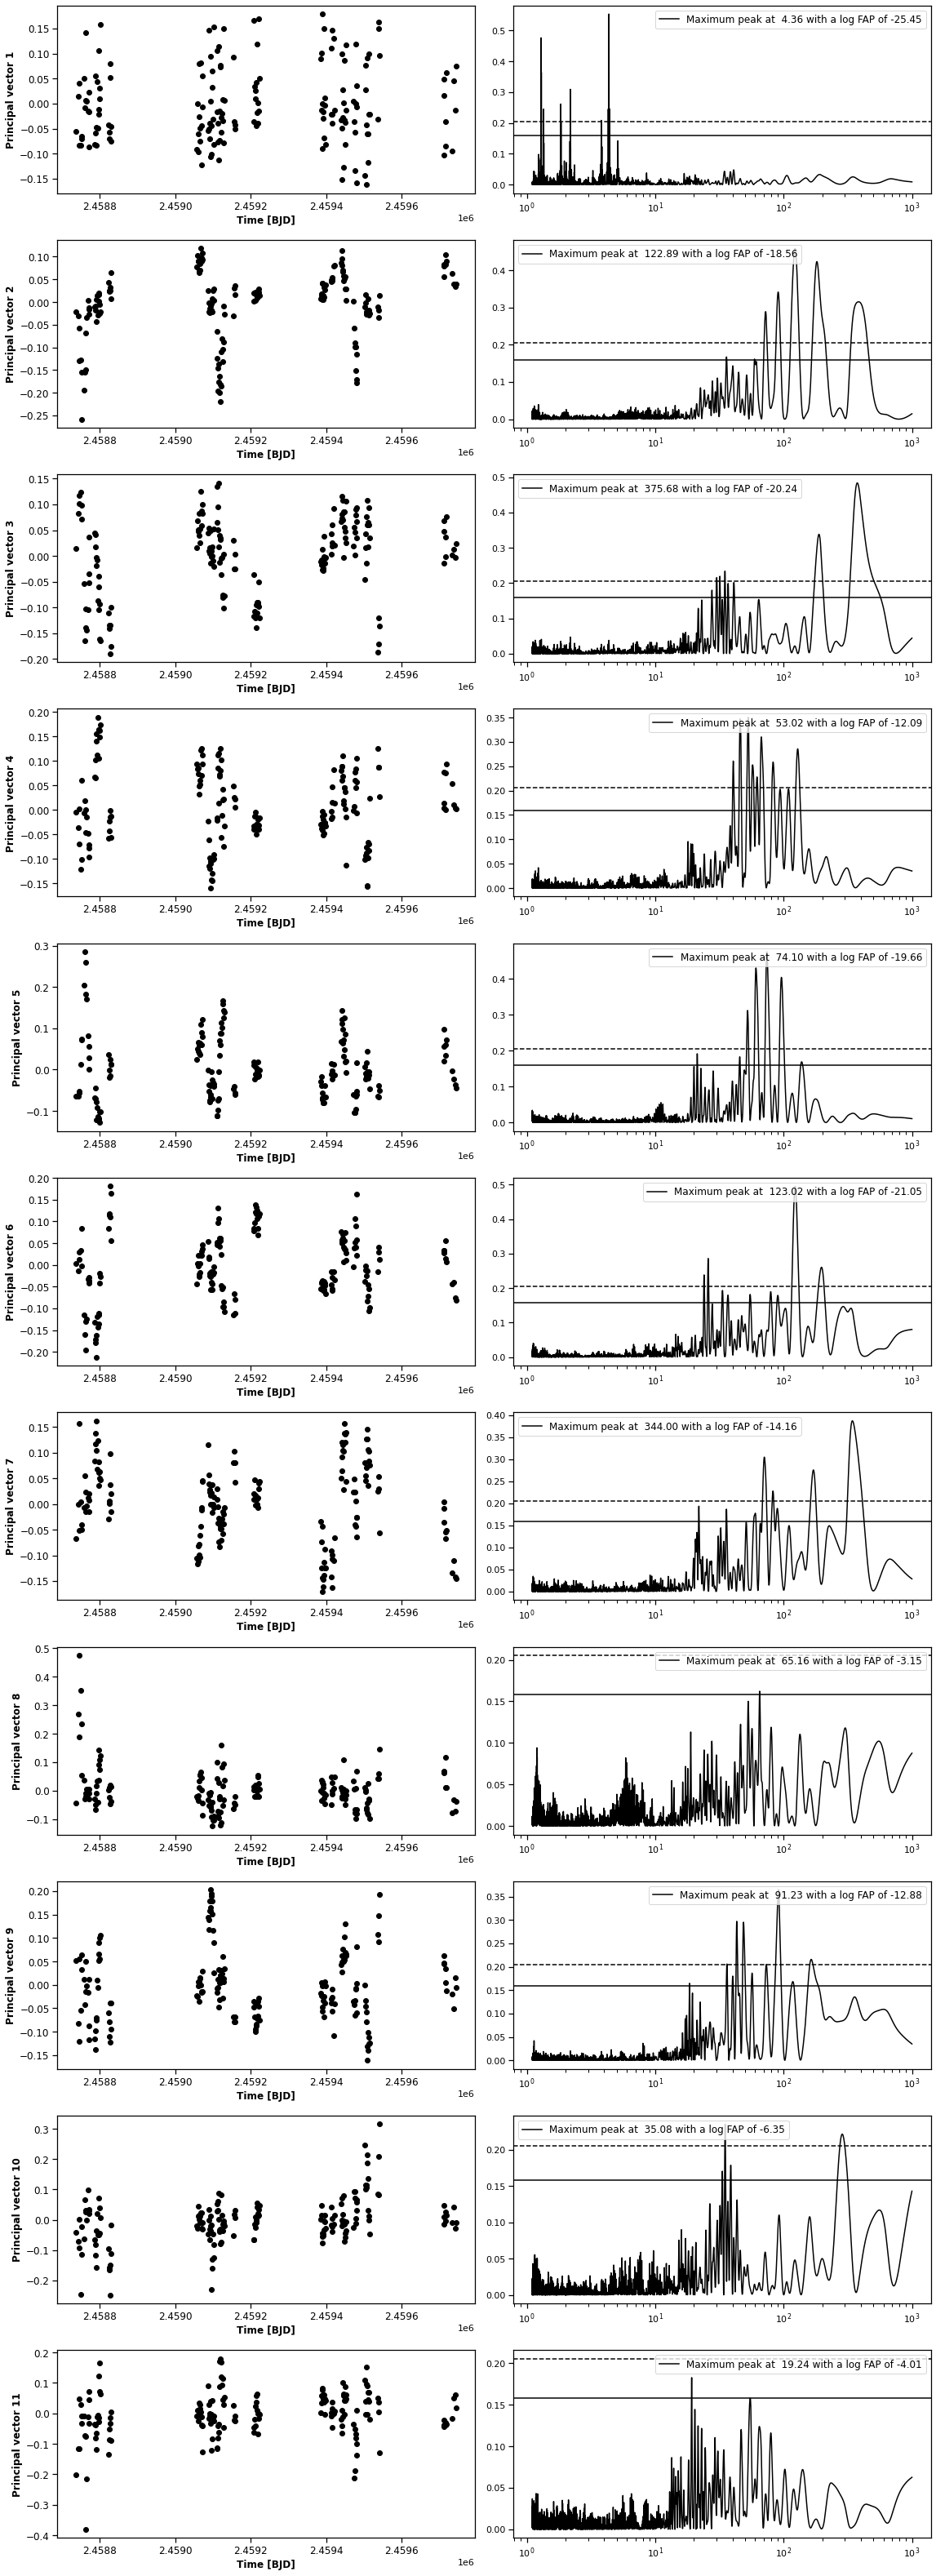

In [30]:
fig, ax = plt.subplots(n_components, 2, figsize=(16, n_components*4))

for n in range(n_components):
    
    ax[n, 0].plot(time_binned, pca.components_[n], 'ko')
    
    ax[n, 0].set_ylabel(f'Principal vector {n+1}', size=12, weight='bold')
    # Set the x-axis label
    ax[n, 0].set_xlabel('Time [BJD]', size=12, weight='bold')
    # Set the font size of the tick labels
    ax[n, 0].tick_params(labelsize=12)

    ls = LombScargle(time_binned, pca.components_[n])
    power = ls.power(frequency)
    fap = ls.false_alarm_probability(power.max())
    ax[n, 1].semilogx(1/frequency, power, 'k-', label=f'Maximum peak at {1/frequency[np.argmax(power)]: .2f} with a log FAP of {np.log10(fap):.2f}')
    fap =ls.false_alarm_probability(power.max())
    ax[n, 1].legend(fontsize=12)

    # false alarm levels
    fap = ls.false_alarm_level(1e-3)
    ax[n, 1].axhline(y=fap,linestyle="-",color="k")
    fap = ls.false_alarm_level(1e-5)
    ax[n, 1].axhline(y=fap,linestyle="--",color="k")


plt.tight_layout()

In [31]:
np.save('/home/paul/Bureau/IRAP/MerwPCAn/out/TablesEV_LAC/firstcomponent.npy', pca.components_[:n_components])
np.save('/home/paul/Bureau/IRAP/MerwPCAn/out/TablesEV_LAC/binnepoc.npy', time_binned) 
np.save('/home/paul/Bureau/IRAP/MerwPCAn/out/TablesEV_LAC/d2vsd2v_mostactive.npy', [d2vs_binned[:, waves_impacted], dd2vs_binned[:, waves_impacted]])
np.save('/home/paul/Bureau/IRAP/MerwPCAn/out/TablesEV_LAC/dvsdv_mostactive.npy', [dvs_binned[:, waves_impacted], ddvs_binned[:, waves_impacted]])